# Чат-бот на transformer


Датасет среднего размера  ~ 9000 строк 

#Setup & Import

In [ ]:
pathName      = "/content/drive/MyDrive/" 
pathNameData  = pathName + "Datasets/" 
pathNameTrain = pathName + "DataTrain/"
prefix        = '_2022_'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dialogs_base_01 = 'chat_bot_config.json'
raw_data_01 = pathNameData + 'chat_bot_config.json'
dialogs_base_02 = '9700 диалоги художка+быт.txt'
raw_data_02 = pathNameData + 'База для чат-ботов/9700 диалоги художка+быт.txt'
raw_data_02_list = pathNameData + 'База для чат-ботов/'

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, Conv1D, SpatialDropout1D, BatchNormalization, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model

import os, re
#import pymorphy2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # модуль для определения форматирования и местоположения делений на осях графиков.


## Load Data

### Raw_data_01

In [ ]:
import codecs, json
with codecs.open(pathNameData + 'BOT_CONFIG1.json', 'r', 'utf-8') as f:
  BOT_CONFIG = json.load(f)

In [ ]:
import sys
# convert to pair (qwestion, answer)
# UPD: add intent
inputs_01 = []
targets_01 = []
intents_01 = []

for i, intent in enumerate(BOT_CONFIG['intents'].items()):
  try:
    if i<1:
      print(intent[1]['examples'])
      print(intent[1]['responses'])
    qwestions = intent[1]['examples']
    answers   = intent[1]['responses']
    
    for q in qwestions:
      for a in answers:
        if i<1:
          print(q, a)
        inputs_01.append(q)
        targets_01.append(a) 
        intents_01.append(intent[0])
  except Exception as e:
    print(i,sys.exc_info()[0], e, )
    #exc_type, exc_obj, exc_tb = sys.exc_info()
    #pass        
    # бывают ошибки
        
print("inputs, targets:")
print(len(list(zip(inputs_01, targets_01, intents_01))))
print(list(zip(inputs_01, targets_01, intents_01))[:5])


['привет!', 'здарова', 'хей-хей!!']
['хай', 'добрый вечер!', 'здравствуйте!']
привет! хай
привет! добрый вечер!
привет! здравствуйте!
здарова хай
здарова добрый вечер!
здарова здравствуйте!
хей-хей!! хай
хей-хей!! добрый вечер!
хей-хей!! здравствуйте!
153 <class 'KeyError'> 'responses'
154 <class 'KeyError'> 'responses'
155 <class 'KeyError'> 'responses'
230 <class 'KeyError'> 'responses'
243 <class 'KeyError'> 'examples'
inputs, targets:
2825
[('привет!', 'хай', 'hello'), ('привет!', 'добрый вечер!', 'hello'), ('привет!', 'здравствуйте!', 'hello'), ('здарова', 'хай', 'hello'), ('здарова', 'добрый вечер!', 'hello')]


### Raw_data_02

In [ ]:
import os
file_lst = os.listdir(raw_data_02_list)
print(file_lst)
# исключим да-нет
file_lst = [fn  for i, fn in enumerate(file_lst) if i!=2 ]
file_lst_codec = ['utf-8' if i!=1 else 'cp1251' for i,_ in enumerate(file_lst) ]
file_lst, file_lst_codec

['5400 диалог политика+ художка -военные, бемби, незнайкак, донцова,анекдот, пух и прочие.txt', '4800диалогов даты, кбжу, суды и шахматы, медицина, еда, имена, камни ,породы, валюта (2).txt', 'Да-нет(3000).txt', '1200.txt', '8 тыс диалоги болталка, общее, энциклопедия разные науки, тесты школьные.txt', '9700 диалоги художка+быт.txt']


(['5400 диалог политика+ художка -военные, бемби, незнайкак, донцова,анекдот, пух и прочие.txt',
  '4800диалогов даты, кбжу, суды и шахматы, медицина, еда, имена, камни ,породы, валюта (2).txt',
  '1200.txt',
  '8 тыс диалоги болталка, общее, энциклопедия разные науки, тесты школьные.txt',
  '9700 диалоги художка+быт.txt'],
 ['utf-8', 'cp1251', 'utf-8', 'utf-8', 'utf-8'])

In [ ]:
import codecs, re
def read_txt(path, codec_):
  with codecs.open(path, 'r', encoding=codec_) as f:
    text = f.read()
    text = text.replace('\ufeff', '')  
    text = re.sub(r'[^А-я0-9\n-!.?]', ' ', text)
    text = re.sub(r'([!.?])', r' \1', text)       # добавляем пробелы перед !.? - чтобы были отдельными токенами
  #text = ' '.join(text.split())
  return text
i = 4
fn, codec_ = file_lst[i], file_lst_codec[i]
path = pathNameData + 'База для чат-ботов/' + fn

text = read_txt(path, codec_)
text[:100]

'    Как вы можете быть таким уверенным ?\n  Элементарно .\n\n    А что делать будем ?\n  Ждать .\n    Над'

In [ ]:
#raw_data_02
texts = []
for i, fn in enumerate(file_lst):
  fn, codec_ = file_lst[i], file_lst_codec[i]
  path = pathNameData + 'База для чат-ботов/' + fn
  texts.append(read_txt(path, codec_))

### Explore raw data - Dataset 02

In [ ]:
i =4
texts[i][:350]

'    Как вы можете быть таким уверенным ?\n  Элементарно .\n\n    А что делать будем ?\n  Ждать .\n    Надеюсь  не до первой звезды ?\n  Я тоже на это надеюсь .\n\n    За что ?\n  Вы знаете за что !\n\n    Ты что нибудь понимаешь ?\n  Абсолютно ничего .\n\n    Обсудим это завтра  ладно ?\n  Хорошо .\n\n    Кто услышит ?\n  Кто кто . .Ну твой следователь .\n\n    Что   '

In [ ]:
separators = [
  ['\r\n\r\n', '\r\n'],
  ['\r\n\r\n', '\r\n'],
  [' .\r\n', '\r\n'],
  ['\r\n\r\n', '\r\n'],
  ['\n\n', '\n' ],             
]

In [ ]:
for i in range(len(texts)):
  print(i, ascii(texts[i][:80]))

0 '    \u041e\u0439  \u0430 \u043f\u043e\u0447\u0435\u043c\u0443 \u0443 \u0432\u0430\u0441 \u0432 \u043a\u0430\u0440\u043c\u0430\u043d\u0435 \u0441\u044b\u0440\u043e ?\r\n  \u0422\u0430\u043a \u043f\u043e\u043b\u0430\u0433\u0430\u0435\u0442\u0441\u044f .\r\n\r\n    \u041a\u043e\u0433\u0434\u0430 \u043d\u0430\u0447\u0438\u043d\u0430\u0435'
1 '    \u041a\u0430\u043a\u043e\u0439 \u043f\u0440\u0430\u0437\u0434\u043d\u0438\u043a \u0432 \u0420\u043e\u0441\u0441\u0438\u0438 \u043e\u0442\u043c\u0435\u0447\u0430\u044e\u0442 10 \u043e\u043a\u0442\u044f\u0431\u0440\u044f ?\r\n  \u0414\u0435\u043d\u044c \u0440\u0430\u0431\u043e\u0442\u043d\u0438\u043a\u0430 \u0441\u0435\u043b\u044c\u0441\u043a\u043e\u0433\u043e \u0445\u043e'
2 '    \u041a\u0430\u043a\u043e\u0432\u044b \u043f\u043e\u0441\u043b\u0435\u0434\u0441\u0442\u0432\u0438\u044f \u043f\u043e\u0440\u0430\u0436\u0435\u043d\u0438\u044f \u043c\u043e\u0437\u0436\u0435\u0447\u043a\u0430 ?\r\n  \u0422\u0438\u043f\u0438\u0447\u043d\u043e\u0439 \u0434

##Data Prepare

### Split pairs

In [ ]:
def split_texts_by_pair(text, seps):
  #print(ascii(seps[0]))
  qa = text.split(seps[0])        # разделитель между парами вопросов

  qa2 = [pair_qa.split(seps[1]) for pair_qa in qa] # разделитель внтури пар вопросов
  return qa2
i = 4
qa = split_texts_by_pair(texts[i], separators[i])
len(qa),qa[:3]

(9211,
 [['    Как вы можете быть таким уверенным ?', '  Элементарно .'],
  ['    А что делать будем ?',
   '  Ждать .',
   '    Надеюсь  не до первой звезды ?',
   '  Я тоже на это надеюсь .'],
  ['    За что ?', '  Вы знаете за что !']])

In [ ]:
qa2 = []
for i in range(len(texts)):
  qa2.append(split_texts_by_pair(texts[i], separators[i]))
  print(len(qa2[-1]), qa2[-1][:2])

5275 [['    Ой  а почему у вас в кармане сыро ?', '  Так полагается .'], ['    Когда начинаеться сезон фрукта Манго         ?', '  Сезон длятся круглогодично  пик в Таиланде с марта по май  во Вьетнаме зимой и весной  в Индонезии с сентября по декабрь .']]
4579 [['    Какой праздник в России отмечают 10 октября ?', '  День работника сельского хозяйства и перерабатывающей промышленности .'], ['    Кто такой Дарт Вейдер ?', '  Дарт Вейдер был оригинальным темным лордом для Звездных войн . Дарт Вейдер правил и страхом  и агрессией . Первоначально Энакин Скайуокер был молодым джедаем  которого затем соблазнила темная сторона силы канцлера Палпатина Дарта Сидиуса .']]
552 [['    Каковы последствия поражения мозжечка ?', '  Типичной для поражения мозжечка является мышечная гипотония'], ['    Что кушают молодые гадюки ?', '  Молодые гадюки в основном кормятся рептилиями и земноводными']]
7836 [['    Как дела ?', '  Все хорошо .'], ['    Где ты живешь ?', '  Я живу во Вселенной .']]
9211 [['  

In [ ]:
len(qa2), qa2[-1]

### Exclude incorrectly placed data - Dataset 02

In [ ]:
# Dataset 02
# ошибочно размеченные  данные
def exlude_incorect_pairs(qa2):
  inputs_02 = []
  targets_02 = []
  err_02 = []
  for i, pair_qa in enumerate(qa2):
    if len(pair_qa) !=2: # (или только вопрос, или больше чем просто вопрос ответ)
      #print("error 'not pair':", i, len(pair_qa), pair_qa)
      err_02.append([ i, 'not pair', len(pair_qa), pair_qa])
      # Исключим диалоги, где больше чем просто вопрос-ответ или просто вопрос
    else:
      #if len(pair_qa[0][4:].strip()) > 0 and len(pair_qa[1][2:].strip()) > 0:
      if len(pair_qa[0].strip()) > 0 and len(pair_qa[1].strip()) > 0:
        inputs_02.append(pair_qa[0][4:].strip()) # пропускаем "- - "
        targets_02.append(pair_qa[1][2:].strip()) # пропускаем "- "
      else:
        print("error 'empty':",i, len(pair_qa), pair_qa)
        err_02.append([ i, 'empty', len(pair_qa), pair_qa])
        # исключаем строки, где хотя бы вопрос или ответ - пустые, или неправильная разметка вопроса
  return inputs_02, targets_02, err_02

In [ ]:
inputs_02, targets_02, err_02 = [], [], []
for i in range(len(qa2)):
  inputs_02_, targets_02_, err_02_ = exlude_incorect_pairs(qa2[i])
  inputs_02.append(inputs_02_); targets_02.append(targets_02_), err_02.append(err_02_)
  print(file_lst[i])  
  print(list(zip(inputs_02[-1], targets_02[-1]))[:5])
  #exclude_rows = len(list(zip(inputs_02, targets_02))) - len(qa2)
  exclude_rows = len(err_02[-1])
  print(f"В итоге {len(list(zip(inputs_02[-1], targets_02[-1])))} пар, исключено {exclude_rows} строк")
  print("Примеры ошибок:")
  filter_ = 'empty'
  print(filter_, ":", list(filter(lambda x: x[1] == filter_, err_02[-1]))[:2])
  filter_ = 'not pair'
  print(filter_, ":", list(filter(lambda x: x[1] == filter_, err_02[-1]))[:2])
  print()

5400 диалог политика+ художка -военные, бемби, незнайкак, донцова,анекдот, пух и прочие.txt
[('Ой  а почему у вас в кармане сыро ?', 'Так полагается .'), ('Когда начинаеться сезон фрукта Манго         ?', 'Сезон длятся круглогодично  пик в Таиланде с марта по май  во Вьетнаме зимой и весной  в Индонезии с сентября по декабрь .'), ('Чем характеризуется 16 я неделя беремености ?', 'Вес тела женщины увеличился еще на один два килограмма . В этот период желателен прием витамина А . Он способствует активному развитию малыша  нормальному набору веса  обновлению слизистых оболочек и эпителия плода . У девочек в этот момент происходит один из самых важных процессов   формирование их собственных яйцеклеток . Нарушения на этом этапе могут привести к бесплодию будущей женщины .'), ('Чем особен фрукт Манго         ?', 'Один из самых популярных фруктов во всех тропических странах . Плоды крупные  яйцевидной  удлиненной или шаровидной формы . Мякоть желтая и оранжевая  сочная  сладкая . Запах манго

In [ ]:
len(inputs_02)

5

### Normilze string & Add tags

In [ ]:
s = "m  ага!i1.2    ?3    агаff  яяsdasda    "
print(f"'{s}'")
s = re.sub(r'([!.?])', r' \1', s)
print(f"'{s}'")
s = re.sub(r'[^а-яА-Я!.?]+', r' ', s)
print(f"'{s}'")
re.sub(r'\s+', r' ', "y!i1.2    ?3a     sdasda")
print(f"'{s}'")

'm  ага!i1.2    ?3    агаff  яяsdasda    '
'm  ага !i1 .2     ?3    агаff  яяsdasda    '
' ага ! . ? ага яя '
' ага ! . ? ага яя '


In [ ]:
import unicodedata
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = s.replace(u'\xa0',"")
    #s = re.sub(r'([!.?])', r' \1', s)       # добавляем пробелы перед !.? - чтобы были отдельными токенами
    #s = re.sub(r'[^а-яА-Я!.?]+', r' ', s)   # оcтавляем только буквы и !.?
    #s = re.sub(r'[^а-яА-Я]+', r' ', s)   # оcтавляем только буквы
    s = re.sub(r'[^A-яA-z0-9-]+', r' ', s)   # оcтавляем только буквы и цифры
    # исключим !.? - они будут лишними -  при них в seq2seq получаются - предварительно - плохие результаты
    s = re.sub(r'\s+', r' ', s).strip()             # убираем лишние пробелы - без strip() остаются "окаёмочки"
    
    return s
s = "m  ага!i1.2    ?3    агаff  яяsdasda    "
normalize_string(s)

'm ага i1 2 3 агаff яяsdasda'

#### Dataset 01

In [ ]:
# raw_data_01
# для одного корпуса текста
inputs_01_ = [normalize_string(data) for data in inputs_01]
intents_01_ = [normalize_string(data) for data in intents_01]
targets_01_in = ['<start> ' + normalize_string(data) for data in targets_01]
targets_01_out = [normalize_string(data) + ' <end>' for data in targets_01]


print(len(inputs_01_), inputs_01_[:3])
print(len(intents_01_), intents_01_[:3])
print(len(targets_01_in), targets_01_in[:3])
print(len(targets_01_out), targets_01_out[:3])

2825 ['привет', 'привет', 'привет']
2825 ['hello', 'hello', 'hello']
2825 ['<start> хаи', '<start> добрыи вечер', '<start> здравствуите']
2825 ['хаи <end>', 'добрыи вечер <end>', 'здравствуите <end>']


#### Dataset 02

In [ ]:
# raw_data_02
# для одного корпуса текста
# inputs_02_ = [normalize_rus_string(data) for data in inputs_02]
# targets_02_in = ['<start> ' + normalize_rus_string(data) for data in targets_02]
# targets_02_out = [normalize_rus_string(data) + ' <end>' for data in targets_02]

# выберем при необходимости отдельные наборы текстов
inds_b_e = [0,4] # inds_begin_end

# для всех корпусов текстов (всех считанных диалогов)
inputs_02_ = [normalize_string(data) for inputs in inputs_02[inds_b_e[0]:inds_b_e[1]+1] for data in inputs ]
targets_02_in = ['<start> ' + normalize_string(data) for targets in targets_02[inds_b_e[0]:inds_b_e[1]+1] for data in targets ]
targets_02_out = [normalize_string(data) + ' <end>' for targets in targets_02[inds_b_e[0]:inds_b_e[1]+1] for data in targets ]

print(len(inputs_02_), inputs_02_[:3])
print(len(targets_02_in), targets_02_in[:3])
print(len(targets_02_out), targets_02_out[:3])

26048 ['Ои а почему у вас в кармане сыро', 'Когда начинаеться сезон фрукта Манго', 'Чем характеризуется 16 я неделя беремености']
26048 ['<start> Так полагается', '<start> Сезон длятся круглогодично пик в Таиланде с марта по маи во Вьетнаме зимои и веснои в Индонезии с сентября по декабрь', '<start> Вес тела женщины увеличился еще на один два килограмма В этот период желателен прием витамина А Он способствует активному развитию малыша нормальному набору веса обновлению слизистых оболочек и эпителия плода У девочек в этот момент происходит один из самых важных процессов формирование их собственных яицеклеток Нарушения на этом этапе могут привести к бесплодию будущеи женщины']
26048 ['Так полагается <end>', 'Сезон длятся круглогодично пик в Таиланде с марта по маи во Вьетнаме зимои и веснои в Индонезии с сентября по декабрь <end>', 'Вес тела женщины увеличился еще на один два килограмма В этот период желателен прием витамина А Он способствует активному развитию малыша нормальному набору 

In [ ]:
len(inputs_02_)

26048

### Explore Data: lenthgs

In [ ]:
#words_lens_i_01 = [len(item.split()) for item in inputs_01]
words_lens_i_01 = [len(item.split()) for item in inputs_01_]
max_words_lens_i_01 = max(words_lens_i_01)
print("max_words_lens_i_01:", max_words_lens_i_01)
words_lens_t_01 = [len(item.split()) for item in targets_01_in]
max_words_lens_t_01 = max(words_lens_t_01)
print("max_words_lens_t_01:", max_words_lens_t_01)

words_lens_int_01 = [len(item.split()) for item in intents_01_]
max_words_lens_int_01 = max(words_lens_int_01)
print("max_words_lens_int_01:", max_words_lens_int_01)


max_words_lens_i_01: 12
max_words_lens_t_01: 32
max_words_lens_int_01: 4


In [ ]:
words_lens_i_02 = [len(item.split()) for item in inputs_02_]
max_words_lens_i_02 = max(words_lens_i_02)
print("max_words_lens_i_02:", max_words_lens_i_02)
words_lens_t_02 = [len(item.split()) for item in targets_02_in]
max_words_lens_t_02 = max(words_lens_t_02)
print("max_words_lens_t_02:", max_words_lens_t_02)

max_words_lens_i_02: 56
max_words_lens_t_02: 267


Есть иногда очень странные ответы длиннные и пространные надопосмотреть до какого размера можно сократить наборы

Проанализириуем при помощи гистограмм

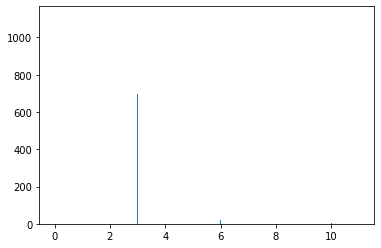

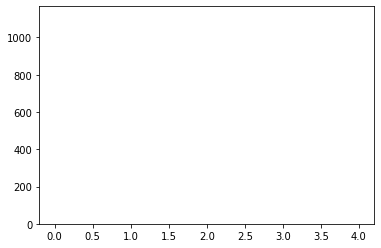

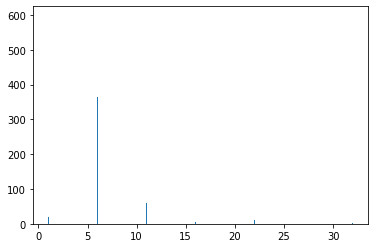

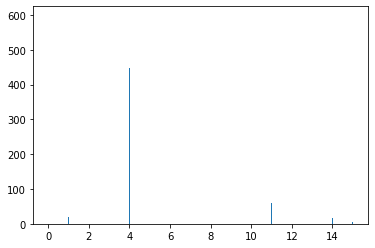

In [ ]:
# dataset_01
plt.hist(words_lens_i_01, bins=1000)
plt.show()
plt.hist(words_lens_i_01, bins=1000, range=(0,
                                            4))
plt.show()

plt.hist(words_lens_t_01, bins=1000)
plt.show()
plt.hist(words_lens_t_01, bins=1000, range=(0,15))
plt.show()



In [ ]:
print(" Dataset 01")
print("Макс кол-во слов q/a до анализа", f"{max_words_lens_i_01}/{max_words_lens_t_01}")
# Переназначаем максимальные длины
max_words_lens_i_01, max_words_lens_t_01 = 5, 15
print("Макс кол-во слов q/a после анализа", f"{max_words_lens_i_01}/{max_words_lens_t_01}")

 Dataset 01
Макс кол-во слов q/a до анализа 12/32
Макс кол-во слов q/a после анализа 5/15


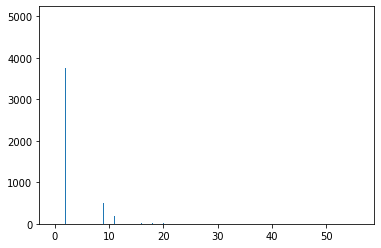

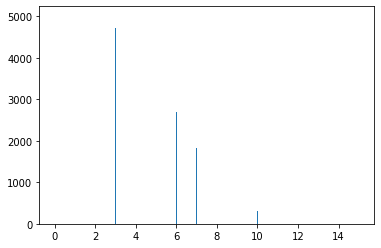

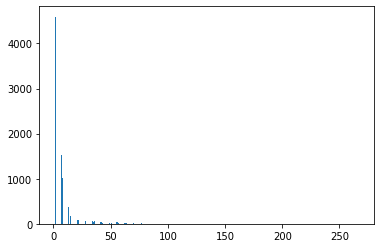

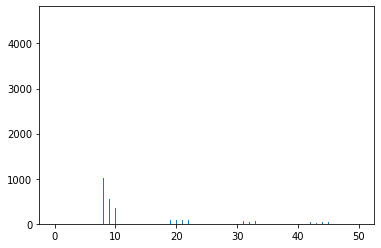

In [ ]:
# dataset_02
plt.hist(words_lens_i_02, bins=1000)
plt.show()
plt.hist(words_lens_i_02, bins=1000, range=(0,15))
plt.show()

plt.hist(words_lens_t_02, bins=1000)
plt.show()
plt.hist(words_lens_t_02, bins=1000, range=(0,50))
plt.show()

In [ ]:
print(" Dataset 02")
print("Макс кол-во слов q/a до анализа", f"{max_words_lens_i_02}/{max_words_lens_t_02}")
# Переназначаем максимальные длины
max_words_lens_i_02, max_words_lens_t_02 = 12, 15
print("Макс кол-во слов q/a после анализа", f"{max_words_lens_i_02}/{max_words_lens_t_02}")

 Dataset 02
Макс кол-во слов q/a до анализа 56/267
Макс кол-во слов q/a после анализа 12/15


### Exclude pairs over max lengths

#### Dataset 01

In [ ]:
print("Dataset 01: длина - ", len(inputs_01_) )
indexes_in_01 = [i for i in range(len(inputs_01_)) if len(inputs_01_[i].split()) > max_words_lens_i_01]
#indexes_in = [i for i in range(len(inputs_01_)) if len(inputs_01_[i].split()) > 5]
print("> max_words_lens_i_01", len(indexes_in_01), indexes_in_01)
indexes_t_01 = [i for i in range(len(targets_01_in)) if len(targets_01_in[i].split()) > max_words_lens_t_01]
#indexes_t = [i for i in range(len(targets_01_in)) if len(targets_01_in[i].split()) > 15]
print("> max_words_lens_t_01", len(indexes_t_01), indexes_t_01)

Dataset 01: длина -  2825
> max_words_lens_i_01 47 [327, 628, 629, 630, 631, 632, 633, 634, 635, 636, 736, 737, 738, 745, 746, 747, 754, 755, 756, 980, 981, 989, 1066, 1067, 1068, 1069, 1111, 1112, 1113, 1457, 1458, 1459, 1526, 1527, 1528, 1664, 1665, 1666, 1989, 1990, 1991, 2132, 2133, 2134, 2235, 2236, 2237]
> max_words_lens_t_01 34 [986, 987, 988, 989, 990, 1063, 1065, 1067, 1069, 1071, 1073, 1075, 1077, 1114, 1117, 1120, 1413, 1416, 1419, 1557, 1558, 1560, 1561, 1565, 1566, 2667, 2670, 2673, 2677, 2680, 2683, 2685, 2688, 2691]


In [ ]:
inputs_01_e = [item for i, item in enumerate(inputs_01_) if not (i in indexes_in_01 or i in indexes_t_01)]
# из-за пересечения over длин в inputs и targets
print(len(inputs_01_), '<=', len(inputs_01_e), '+', len(indexes_in_01), '+', len(indexes_t_01))

intents_01_e = [item for i, item in enumerate(intents_01_) if not (i in indexes_in_01 or i in indexes_t_01)]
# из-за пересечения over длин в inputs и targets
print(len(intents_01_), '<=', len(intents_01_e), '+', len(indexes_in_01), '+', len(indexes_t_01))

targets_01_in_e = [item for i, item in enumerate(targets_01_in) if not (i in indexes_in_01 or i in indexes_t_01)]
# из-за пересечения over длин в inputs и targets
print(len(targets_01_in), '<=', len(targets_01_in_e), '+', len(indexes_in_01), '+', len(indexes_t_01))
targets_01_out_e = [item for i, item in enumerate(targets_01_out) if not (i in indexes_in_01 or i in indexes_t_01)]
# из-за пересечения over длин в inputs и targets
print(len(targets_01_out), '<=', len(targets_01_out_e), '+', len(indexes_in_01), '+', len(indexes_t_01))

2825 <= 2747 + 47 + 34
2825 <= 2747 + 47 + 34
2825 <= 2747 + 47 + 34
2825 <= 2747 + 47 + 34


#### Dataset 02

In [ ]:
print("Dataset 02")
indexes_in_02 = [i for i in range(len(inputs_02_)) if len(inputs_02_[i].split()) > max_words_lens_i_02]
print(len(indexes_in_02), indexes_in_02)
indexes_t_02 = [i for i in range(len(targets_02_in)) if len(targets_02_in[i].split()) > max_words_lens_t_02]
#indexes_t = [i for i in range(len(targets_02_in)) if len(targets_02_in[i].split()) > 15]
print(len(indexes_t_02), indexes_t_02)

Dataset 02
351 [14, 107, 160, 492, 1232, 1233, 5899, 6241, 6242, 6358, 6361, 6363, 6369, 6370, 6372, 6373, 6799, 6803, 6804, 6865, 6962, 7137, 7217, 7298, 7321, 9608, 9611, 9617, 9619, 9672, 9675, 9677, 9681, 9702, 9770, 9783, 9858, 9860, 9869, 9874, 9880, 10116, 10140, 10207, 10235, 10300, 10327, 10387, 10403, 10527, 10566, 10670, 10674, 10679, 10680, 10689, 10690, 11029, 11033, 11050, 11053, 11064, 11077, 11080, 11082, 11083, 11084, 11086, 11106, 11109, 11161, 11226, 11329, 11802, 11803, 11811, 11856, 11857, 11858, 11867, 11881, 11884, 11890, 11891, 11900, 11923, 11930, 11938, 11943, 11947, 11950, 11979, 11981, 11983, 11987, 11991, 11995, 11999, 12009, 12105, 12109, 12120, 12174, 12181, 12198, 12286, 12353, 12408, 12410, 12421, 12422, 12451, 12558, 12572, 12580, 12583, 12596, 12605, 12621, 12632, 12667, 12741, 12784, 12807, 12818, 12857, 12921, 12948, 12974, 12975, 12987, 12993, 13007, 13080, 13196, 13231, 13248, 13271, 13327, 13378, 13380, 13383, 13405, 13427, 13482, 13493, 13497, 1

In [ ]:
inputs_02_e = [item for i, item in enumerate(inputs_02_) if not (i in indexes_in_02 or i in indexes_t_02)]
# из-за пересечения over длин в inputs и targets
print(len(inputs_02_), '<=', len(inputs_02_e), '+', len(indexes_in_02), '+', len(indexes_t_02),
      ":", len(inputs_02_e) + len(indexes_in_02) + len(indexes_t_02))
targets_02_in_e = [item for i, item in enumerate(targets_02_in) if not (i in indexes_in_02 or i in indexes_t_02)]
# из-за пересечения over длин в inputs и targets
print(len(targets_02_in), '<=', len(targets_02_in_e), '+', len(indexes_in_02), '+', len(indexes_t_02),
      ":", len(targets_02_in_e) + len(indexes_in_02) + len(indexes_t_02))
targets_02_out_e = [item for i, item in enumerate(targets_02_out) if not (i in indexes_in_02 or i in indexes_t_02)]
# из-за пересечения over длин в inputs и targets
print(len(targets_02_out), '<=', len(targets_02_out_e), '+', len(indexes_in_02), '+', len(indexes_t_02),
      ":", len(targets_02_out_e) + len(indexes_in_02) + len(indexes_t_02))

26048 <= 22926 + 351 + 2810 : 26087
26048 <= 22926 + 351 + 2810 : 26087
26048 <= 22926 + 351 + 2810 : 26087


### Save Load data

In [ ]:
# Save
import pickle
with open(pathNameTrain + prefix + 'inputs_01_', 'wb') as handle:
  pickle.dump(inputs_01_, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'intents_01_', 'wb') as handle:
  pickle.dump(intents_01_, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_01_in', 'wb') as handle:
  pickle.dump(targets_01_in, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_01_out', 'wb') as handle:
  pickle.dump(targets_01_out, handle, protocol=pickle.HIGHEST_PROTOCOL)  

with open(pathNameTrain + prefix + 'inputs_01_e', 'wb') as handle:
  pickle.dump(inputs_01_e, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'intents_01_e', 'wb') as handle:
  pickle.dump(intents_01_e, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(pathNameTrain + prefix + 'targets_01_in_e', 'wb') as handle:
  pickle.dump(targets_01_in_e, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_01_out_e', 'wb') as handle:
  pickle.dump(targets_01_out_e, handle, protocol=pickle.HIGHEST_PROTOCOL)    

with open(pathNameTrain + prefix + 'inputs_02_', 'wb') as handle:
  pickle.dump(inputs_02_, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_02_in', 'wb') as handle:
  pickle.dump(targets_02_in, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_02_out', 'wb') as handle:
  pickle.dump(targets_02_out, handle, protocol=pickle.HIGHEST_PROTOCOL)  

with open(pathNameTrain + prefix + 'inputs_02_e_9700', 'wb') as handle:
  pickle.dump(inputs_02_e, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_02_in_e_9700', 'wb') as handle:
  pickle.dump(targets_02_in_e, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pathNameTrain + prefix + 'targets_02_out_e_9700', 'wb') as handle:
  pickle.dump(targets_02_out_e, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
# Load без исключенных по длине строк
import pickle
with open(pathNameTrain + prefix + 'inputs_01_', 'rb') as handle:
  inputs_01_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'intents_01_', 'rb') as handle:
  intents_01_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_01_in', 'rb') as handle:
  targets_01_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_01_out', 'rb') as handle:
  targets_01_out = pickle.load(handle)

with open(pathNameTrain + prefix + 'inputs_02_', 'rb') as handle:
  inputs_02_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_in', 'rb') as handle:
  targets_02_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_out', 'rb') as handle:
  targets_02_out = pickle.load(handle)

In [ ]:
# Load с  исключенными по длине строками
import pickle
with open(pathNameTrain + prefix + 'inputs_01_e', 'rb') as handle:
  inputs_01_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'intents_01_e', 'rb') as handle:
  intents_01_ = pickle.load(handle)

with open(pathNameTrain + prefix + 'targets_01_in_e', 'rb') as handle:
  targets_01_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_01_out_e', 'rb') as handle:
  targets_01_out = pickle.load(handle)

with open(pathNameTrain + prefix + 'inputs_02_e', 'rb') as handle:
  inputs_02_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_in_e', 'rb') as handle:
  targets_02_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_out_e', 'rb') as handle:
  targets_02_out = pickle.load(handle)

# Переназначаем максимальные длины
max_words_lens_i_01, max_words_lens_t_01, max_words_lens_int_01 = 5, 15, 4
# Переназначаем максимальные длины
max_words_lens_i_02, max_words_lens_t_02 = 12, 15


In [ ]:
# тольк последний набор
with open(pathNameTrain + prefix + 'inputs_02_e_9700', 'rb') as handle:
  inputs_02_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_in_e_9700', 'rb') as handle:
  targets_02_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_out_e_9700', 'rb') as handle:
  targets_02_out = pickle.load(handle)

# Переназначаем максимальные длины
max_words_lens_i_02, max_words_lens_t_02 = 12, 15

### Vectorize/Tokenize Data

In [ ]:
import string
t = Tokenizer()
print(t.filters)
filters_default = t.filters
string.whitespace

!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



' \t\n\r\x0b\x0c'

In [ ]:
print(f"string.punctuation: {string.punctuation}")
print(f"filters_default: '{filters_default}'")
#filters_correct=filters_default.replace('<','').replace('>','') + f'{string.whitespace.strip()}'
filters_correct=filters_default.replace('<','').replace('>','') + '\t\n\r\x0b\x0c'
# оставляем < > 
print(f"filters_correct: '{filters_correct}'")
#filters_correct + string.whitespace.strip()

string.punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
filters_default: '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	
'
filters_correct: '!"#$%&()*+,-./:;=?@[\]^_`{|}~	
	
'


In [ ]:
#%%time
#tokenizer_01 = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_01 = tf.keras.preprocessing.text.Tokenizer(filters=filters_correct)
tokenizer_01.fit_on_texts(inputs_01_ + targets_01_in + targets_01_out + intents_01_)
voc_size_01 = len(tokenizer_01.word_index)
print("voc_size_01:", voc_size_01)
print(list(tokenizer_01.word_index)[:10] )
print('<start>', tokenizer_01.word_index['<start>'], '<end>', tokenizer_01.word_index['<end>'])
print('hello', tokenizer_01.word_index['hello']) #, tokenizer_01.word_index['<end>'])

max_len_inputs_choice_01 = max(max_words_lens_i_01, max_words_lens_int_01)

inputs_01_seq = tokenizer_01.texts_to_sequences(inputs_01_)
inputs_01_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(inputs_01_seq, padding='post',
        truncating='post', maxlen=max_len_inputs_choice_01 )

intents_01_seq = tokenizer_01.texts_to_sequences(intents_01_)
intents_01_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(intents_01_seq, padding='post',
        truncating='post', maxlen=max_len_inputs_choice_01 )

targets_01_in_seq = tokenizer_01.texts_to_sequences(targets_01_in)
targets_01_in_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_01_in_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_01 )
targets_01_out_seq = tokenizer_01.texts_to_sequences(targets_01_out)
targets_01_out_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_01_out_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_01 )

print(inputs_01_seq_pad.shape, intents_01_seq_pad.shape, targets_01_in_seq_pad.shape, targets_01_out_seq_pad.shape)

voc_size_01: 2194
['<start>', '<end>', 'я', 'не', 'в', 'как', 'что', 'ты', 'и', 'все']
<start> 1 <end> 2
hello 711
(2747, 5) (2747, 5) (2747, 15) (2747, 15)


In [ ]:
# dataset 02
%%time
tokenizer_02 = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_02.fit_on_texts(inputs_02_ + targets_02_in + targets_02_out)
voc_size_02 = len(tokenizer_02.word_index)
print("voc_size_02:", voc_size_02)
print(list(tokenizer_02.word_index)[:10] )

print(tokenizer_02.word_index['<start>'], tokenizer_02.word_index['<end>'])

inputs_02_seq = tokenizer_02.texts_to_sequences(inputs_02_)
inputs_02_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(inputs_02_seq, padding='post',
        truncating='post', maxlen=max_words_lens_i_02 )
targets_02_in_seq = tokenizer_02.texts_to_sequences(targets_02_in)
targets_02_in_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_02_in_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_02 )
targets_02_out_seq = tokenizer_02.texts_to_sequences(targets_02_out)
targets_02_out_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_02_out_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_02 )

print(inputs_02_seq_pad.shape, targets_02_in_seq_pad.shape, targets_02_out_seq_pad.shape)

voc_size_02: 31196
['<start>', '<end>', 'не', 'в', 'я', 'что', 'ты', 'а', 'это', 'да']
1 2
(22926, 12) (22926, 15) (22926, 15)
CPU times: user 1.64 s, sys: 88.9 ms, total: 1.73 s
Wall time: 1.66 s


### Create & Split Datasets

In [ ]:
BATCH_SIZE = 5
# выберем поменьше (так свотеалина рзборах от 2-3 до 6-8)

In [ ]:
%%time
dataset_01 = tf.data.Dataset.from_tensor_slices((inputs_01_seq_pad, targets_01_in_seq_pad, targets_01_out_seq_pad))
dataset_01 = dataset_01.shuffle(20).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 3.12 ms


In [ ]:
%%time
dataset_01 = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(inputs_01_seq_pad).batch(BATCH_SIZE), 
    tf.data.Dataset.from_tensor_slices(targets_01_in_seq_pad).batch(BATCH_SIZE), 
    tf.data.Dataset.from_tensor_slices(targets_01_out_seq_pad).batch(BATCH_SIZE)))
dataset_01 = dataset_01.shuffle(20).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

CPU times: user 6.98 ms, sys: 0 ns, total: 6.98 ms
Wall time: 6.82 ms


In [ ]:
len(dataset_01)

565

In [ ]:
train_size = 0.8
#len_train_01 = np.ceil(len(dataset_01)*train_size) # в batches
len_train_01 = int(len(dataset_01)*train_size) # в batches

ds_01_train = dataset_01.take(len_train_01) 
ds_01_test  = dataset_01.skip(len_train_01)

print(len(ds_01_train), ds_01_train.as_numpy_iterator , len(ds_01_test), ds_01_test.as_numpy_iterator)
it_train = ds_01_train.take(1); it_test = ds_01_test.take(1)
print(len(ds_01_test), it.element_spec, it_test.element_spec)

90 <bound method DatasetV2.as_numpy_iterator of <TakeDataset shapes: ((None, None, 12), (None, None, 45), (None, None, 45)), types: (tf.int32, tf.int32, tf.int32)>> 23 <bound method DatasetV2.as_numpy_iterator of <SkipDataset shapes: ((None, None, 12), (None, None, 45), (None, None, 45)), types: (tf.int32, tf.int32, tf.int32)>>
23 (TensorSpec(shape=(None, None, 12), dtype=tf.int32, name=None), TensorSpec(shape=(None, None, 45), dtype=tf.int32, name=None), TensorSpec(shape=(None, None, 45), dtype=tf.int32, name=None)) (TensorSpec(shape=(None, None, 12), dtype=tf.int32, name=None), TensorSpec(shape=(None, None, 45), dtype=tf.int32, name=None), TensorSpec(shape=(None, None, 45), dtype=tf.int32, name=None))


In [ ]:
%%time
dataset_02 = tf.data.Dataset.from_tensor_slices((inputs_02_seq_pad, targets_02_in_seq_pad, targets_02_out_seq_pad))
#dataset_02 = tf.data.Dataset.zip((inputs_02_seq_pad, targets_02_in_seq_pad, targets_02_out_seq_pad))
dataset_02 = dataset_02.shuffle(20).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

CPU times: user 4.16 ms, sys: 0 ns, total: 4.16 ms
Wall time: 4.11 ms


In [ ]:
dataset_02 = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(inputs_02_seq_pad).batch(BATCH_SIZE), 
    tf.data.Dataset.from_tensor_slices(targets_02_in_seq_pad).batch(BATCH_SIZE), 
    tf.data.Dataset.from_tensor_slices(targets_02_out_seq_pad).batch(BATCH_SIZE)))
dataset_02 = dataset_02.shuffle(20).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_size = 0.8
len_train_02 = np.ceil(len(dataset_02)*train_size) # в batches

ds_02_train = dataset_01.take(len_train_02) 
ds_02_test  = dataset_01.skip(len_train_02)
len(ds_02_train), ds_02_train.as_numpy_iterator , len(ds_02_test), ds_02_test.as_numpy_iterator

(274,
 <bound method DatasetV2.as_numpy_iterator of <TakeDataset shapes: ((None, 12), (None, 45), (None, 45)), types: (tf.int32, tf.int32, tf.int32)>>,
 291,
 <bound method DatasetV2.as_numpy_iterator of <SkipDataset shapes: ((None, 12), (None, 45), (None, 45)), types: (tf.int32, tf.int32, tf.int32)>>)

In [ ]:
it = iter(ds_02_train)
print(next(it))

## Load saved Data

In [ ]:
# Load с  исключенными по длине строками
import pickle
with open(pathNameTrain + prefix + 'inputs_01_e', 'rb') as handle:
  inputs_01_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'intents_01_e', 'rb') as handle:
  intents_01_ = pickle.load(handle)

with open(pathNameTrain + prefix + 'targets_01_in_e', 'rb') as handle:
  targets_01_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_01_out_e', 'rb') as handle:
  targets_01_out = pickle.load(handle)

with open(pathNameTrain + prefix + 'inputs_02_e', 'rb') as handle:
  inputs_02_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_in_e', 'rb') as handle:
  targets_02_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_out_e', 'rb') as handle:
  targets_02_out = pickle.load(handle)

# Переназначаем максимальные длины
max_words_lens_i_01, max_words_lens_t_01, max_words_lens_int_01 = 5, 15, 4
# Переназначаем максимальные длины
max_words_lens_i_02, max_words_lens_t_02 = 12, 15


In [ ]:
import pickle
# для отдельного набора 9700 диалогов
with open(pathNameTrain + prefix + 'inputs_02_e_9700', 'rb') as handle:
  inputs_02_ = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_in_e_9700', 'rb') as handle:
  targets_02_in = pickle.load(handle)
with open(pathNameTrain + prefix + 'targets_02_out_e_9700', 'rb') as handle:
  targets_02_out = pickle.load(handle)


# Переназначаем максимальные длины
max_words_lens_i_02, max_words_lens_t_02 = 11, 13


### Vectorize/Tokenize Data

In [ ]:
import string
t = Tokenizer()
print(t.filters)
filters_default = t.filters
string.whitespace

!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



' \t\n\r\x0b\x0c'

In [ ]:
print(f"string.punctuation: {string.punctuation}")
print(f"filters_default: '{filters_default}'")
#filters_correct=filters_default.replace('<','').replace('>','') + f'{string.whitespace.strip()}'
filters_correct=filters_default.replace('<','').replace('>','') + '\t\n\r\x0b\x0c'
# оставляем < > 
print(f"filters_correct: '{filters_correct}'")
#filters_correct + string.whitespace.strip()

string.punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
filters_default: '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	
'
filters_correct: '!"#$%&()*+,-./:;=?@[\]^_`{|}~	
	
'


In [ ]:
#%%time
#tokenizer_01 = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_01 = tf.keras.preprocessing.text.Tokenizer(filters=filters_correct)
tokenizer_01.fit_on_texts(inputs_01_ + targets_01_in + targets_01_out + intents_01_)
voc_size_01 = len(tokenizer_01.word_index)
print("voc_size_01:", voc_size_01)
print(list(tokenizer_01.word_index)[:10] )
print('<start>', tokenizer_01.word_index['<start>'], '<end>', tokenizer_01.word_index['<end>'])
print('hello', tokenizer_01.word_index['hello']) #, tokenizer_01.word_index['<end>'])

max_len_inputs_choice_01 = max(max_words_lens_i_01, max_words_lens_int_01)

inputs_01_seq = tokenizer_01.texts_to_sequences(inputs_01_)
inputs_01_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(inputs_01_seq, padding='post',
        truncating='post', maxlen=max_len_inputs_choice_01 )

intents_01_seq = tokenizer_01.texts_to_sequences(intents_01_)
intents_01_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(intents_01_seq, padding='post',
        truncating='post', maxlen=max_len_inputs_choice_01 )

targets_01_in_seq = tokenizer_01.texts_to_sequences(targets_01_in)
targets_01_in_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_01_in_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_01 )
targets_01_out_seq = tokenizer_01.texts_to_sequences(targets_01_out)
targets_01_out_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_01_out_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_01 )

print(inputs_01_seq_pad.shape, intents_01_seq_pad.shape, targets_01_in_seq_pad.shape, targets_01_out_seq_pad.shape)

voc_size_01: 2194
['<start>', '<end>', 'я', 'не', 'в', 'как', 'что', 'ты', 'и', 'все']
<start> 1 <end> 2
hello 711
(2747, 5) (2747, 5) (2747, 15) (2747, 15)


In [ ]:
# dataset 02
%%time
tokenizer_02 = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
tokenizer_02.fit_on_texts(inputs_02_ + targets_02_in + targets_02_out)
voc_size_02 = len(tokenizer_02.word_index)
print("voc_size_02:", voc_size_02)
print(list(tokenizer_02.word_index)[:10] )

print(tokenizer_02.word_index['<start>'], tokenizer_02.word_index['<end>'])

inputs_02_seq = tokenizer_02.texts_to_sequences(inputs_02_)
inputs_02_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(inputs_02_seq, padding='post',
        truncating='post', maxlen=max_words_lens_i_02 )
targets_02_in_seq = tokenizer_02.texts_to_sequences(targets_02_in)
targets_02_in_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_02_in_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_02 )
targets_02_out_seq = tokenizer_02.texts_to_sequences(targets_02_out)
targets_02_out_seq_pad = tf.keras.preprocessing.sequence.pad_sequences(targets_02_out_seq, padding='post',
        truncating='post', maxlen=max_words_lens_t_02 )

print(inputs_02_seq_pad.shape, targets_02_in_seq_pad.shape, targets_02_out_seq_pad.shape, 
      #targets_02_seq_pad.shape
      )

voc_size_02: 10472
['<unk>', '<start>', '<end>', 'не', 'что', 'да', 'я', 'а', 'в', 'ты']
2 3
(8553, 11) (8553, 13) (8553, 13)
CPU times: user 896 ms, sys: 14.1 ms, total: 910 ms
Wall time: 2.08 s


### Create Dataset tf.Data.Dataset

In [ ]:
BUFFER_SIZE = len(inputs_02_seq_pad)
BATCH_SIZE  = 32
batch_sz    = BATCH_SIZE

# Создаём датасет из массивов Numpy(рус и анг тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
dataset = tf.data.Dataset.from_tensor_slices((inputs_02_seq_pad, targets_02_in_seq_pad,targets_02_out_seq_pad)).shuffle(BUFFER_SIZE)
# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(batch_sz, drop_remainder=True)

# Посмотрим на форму примеров полученных батчей
example_input_batch, example_target_batch_in, example_target_batch_out = next(iter(dataset))
example_input_batch.shape, example_target_batch_in.shape, example_target_batch_out.shape

(TensorShape([32, 11]), TensorShape([32, 13]), TensorShape([32, 13]))

## Create Model

### Hyper Params

In [ ]:
vocab_size, hidden_dim, max_len_inputs, max_len_targets  = voc_size_02, 256, max_words_lens_i_02, max_words_lens_t_02
target_vocab_size, input_vocab_size = vocab_size+1, vocab_size+1
max_len_input, max_len_target = max_words_lens_i_02, max_words_lens_t_02
input_tokenizer, target_tokenizer = tokenizer_02, tokenizer_02
H = 8 # Heads
NUM_LAYERS = 1

### Positional Embedding/Encoding

In [ ]:
def positional_embedding(pos, hidden_dim):
    PE = np.zeros((1, hidden_dim))
    for i in range(hidden_dim):
        if i % 2 == 0:
            PE[:, i] = np.sin(pos / 10000 ** (i / hidden_dim))
        else:
            PE[:, i] = np.cos(pos / 10000 ** ((i - 1) / hidden_dim))
    return PE

#max_length = max(len(data_en[0]), len(data_fr_in[0]))
max_length = max(max_words_lens_i_02, max_words_lens_t_02)

HIDDEN_DIM = hidden_dim #128

pes = []
for i in range(max_length):
    pes.append(positional_embedding(i, HIDDEN_DIM))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

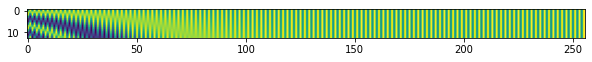

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pes.numpy() )
plt.show()

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, hidden_dim, num_layers, h):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_dim)
        self.attention = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]

        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(512, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(hidden_dim) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

    def call(self, sequence, padding_mask=None):
        embed_out = self.embedding(sequence)
        embed_out += pes[:sequence.shape[1], :]
        
        sub_in = embed_out
        
        for i in range(self.num_layers):
            sub_out = self.attention[i](sub_in, sub_in, padding_mask)
            sub_out = sub_in + sub_out
            sub_out = self.attention_norm[i](sub_out)
            
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = ffn_in + ffn_out
            ffn_out = self.ffn_norm[i](ffn_out)

            sub_in = ffn_out
            
        return ffn_out

### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, hidden_dim, num_layers, h):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_dim)
        self.attention_bot = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(hidden_dim, h) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense_1 = [tf.keras.layers.Dense(512, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(hidden_dim) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, encoder_output, padding_mask=None):
        # Эмбеддинги
        embed_out = self.embedding(sequence)
        embed_out += pes[:sequence.shape[1], :]
        
        bot_sub_in = embed_out
        
        for i in range(self.num_layers):
            # Нижний блок внимания
            seq_len = bot_sub_in.shape[1]
            look_left_only_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            bot_sub_out = self.attention_bot[i](bot_sub_in, bot_sub_in, look_left_only_mask)
            bot_sub_out = bot_sub_in + bot_sub_out
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)
            
            # Верхний блок внимания
            mid_sub_in = bot_sub_out

            mid_sub_out = self.attention_mid[i](mid_sub_in, encoder_output, padding_mask)
            mid_sub_out = mid_sub_out + mid_sub_in
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)

            # Полносвязный слой
            ffn_in = mid_sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)

            bot_sub_in = ffn_out
        
        logits = self.dense(ffn_out)
            
        return logits

### MultiHeadAttention

In [ ]:
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, hidden_dim, h):
        super(MultiHeadAttention, self).__init__()
        self.key_size = hidden_dim // h
        self.h = h
        self.wq = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wk = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wv = tf.keras.layers.Dense(hidden_dim) #замена [tf.keras.layers.Dense(value_size) for _ in range(h)]
        self.wo = tf.keras.layers.Dense(hidden_dim)
    
    def call(self, decoder_output, encoder_output, mask=None):
        
        
        query = self.wq(decoder_output)
        key = self.wk(encoder_output)
        value = self.wv(encoder_output)
        
        # Разделяем для multihead attention
        batch_size = query.shape[0]
        query = tf.reshape(query, [batch_size, -1, self.h, self.key_size])
        query = tf.transpose(query, [0, 2, 1, 3])
        key = tf.reshape(key, [batch_size, -1, self.h, self.key_size])
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.reshape(value, [batch_size, -1, self.h, self.key_size])
        value = tf.transpose(value, [0, 2, 1, 3])
        
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, dtype=tf.float32))
        
        if mask is not None:
            score *= mask
            score = tf.where(tf.equal(score, 0), tf.ones_like(score) * -1e9, score)
        
        a = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(a, value)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.key_size * self.h])
        
        heads = self.wo(context)
        return heads

In [ ]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss


optimizer = tf.keras.optimizers.Adam()

## Train

### Small Test

In [ ]:
#input_vocab_size = vocab_size         # len(input_tokenizer.word_index) + 1
encoder = Encoder(input_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

input_sequence_in = tf.constant([[1, 2, 3, 4, 6, 7, 8, 0, 0, 0], 
                           [1, 2, 3, 4, 6, 7, 8, 0, 0, 0]])
encoder_output = encoder(input_sequence_in)

print('Input vocabulary size', input_vocab_size)
print('Encoder input shape', input_sequence_in.shape)
print('Encoder output shape', encoder_output.shape)

#target_vocab_size = vocab_size        # len(target_tokenizer.word_index) + 1
# max_len_target = max_words_lens_t_02  # data_fr_in.shape[1]
decoder = Decoder(target_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

#target_sequence_in = tf.constant([[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0],
#                           [1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0]])
target_sequence_in = tf.constant([list(range(1, max_len_target+1,1)),
                           list(range(max_len_target))])
decoder_output = decoder(target_sequence_in, encoder_output)

print('Target vocabulary size', target_vocab_size)
print('Decoder input shape', target_sequence_in.shape)
print('Decoder output shape', decoder_output.shape)

Input vocabulary size 10473
Encoder input shape (2, 10)
Encoder output shape (2, 10, 256)
Target vocabulary size 10473
Decoder input shape (2, 13)
Decoder output shape (2, 13, 10473)


### Train Functional

In [ ]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        padding_mask = 1 - tf.cast(tf.equal(source_seq, 0), dtype=tf.float32)
        padding_mask = tf.expand_dims(padding_mask, axis=1)
        padding_mask = tf.expand_dims(padding_mask, axis=1)
        encoder_output = encoder(source_seq, padding_mask)
        
        decoder_output = decoder(target_seq_in, encoder_output, padding_mask)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [ ]:
def predict(test_source_text=None):
    if test_source_text is None:
        test_source_text = inputs_01_[np.random.choice(len(inputs_01_))]
    print(test_source_text)
    test_source_text = normalize_string(test_source_text)
    test_source_seq = input_tokenizer.texts_to_sequences([test_source_text])
    print(test_source_seq)

    en_output = encoder(tf.constant(test_source_seq))

    de_input = tf.constant([[target_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output = decoder(de_input, en_output)
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(target_tokenizer.index_word[new_word.numpy()[0][0]])

        de_input = tf.concat((de_input, new_word), axis=-1)

        if out_words[-1] == '<end>' or len(out_words) >= 14:
            break

    print(' '.join(out_words))

### Train

In [ ]:
import time
encoder = Encoder(input_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)
decoder = Decoder(target_vocab_size, HIDDEN_DIM, NUM_LAYERS, H)

NUM_EPOCHS = 100

start_time = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)

    print('Epoch {} Loss {:.4f}'.format(
          e + 1, loss.numpy()))

    if (e +1) % 10 == 0:
        end_time = time.time()
        print('Среднее время: {:.2f}s'.format((end_time - start_time) / (e + 1)))
        try:
            predict()
        except Exception as e:
            print(e)
            continue

Epoch 1 Loss 1.8218
Epoch 2 Loss 1.8528
Epoch 3 Loss 1.2129
Epoch 4 Loss 1.1436
Epoch 5 Loss 0.9698
Epoch 6 Loss 0.8084
Epoch 7 Loss 0.8534
Epoch 8 Loss 0.4627
Epoch 9 Loss 0.5803
Epoch 10 Loss 0.3995
Среднее время: 5.95s
не фонтан
[[4, 1]]
да <end>
Epoch 11 Loss 0.4098
Epoch 12 Loss 0.2685
Epoch 13 Loss 0.4463
Epoch 14 Loss 0.5233
Epoch 15 Loss 0.3102
Epoch 16 Loss 0.2369
Epoch 17 Loss 0.2819
Epoch 18 Loss 0.3981
Epoch 19 Loss 0.2768
Epoch 20 Loss 0.3107
Среднее время: 5.70s
пришли песню
[[499, 3272]]
это я тоже <end>
Epoch 21 Loss 0.1963
Epoch 22 Loss 0.2533
Epoch 23 Loss 0.2326
Epoch 24 Loss 0.2521
Epoch 25 Loss 0.2440
Epoch 26 Loss 0.1944
Epoch 27 Loss 0.1382
Epoch 28 Loss 0.1828
Epoch 29 Loss 0.2234
Epoch 30 Loss 0.1341
Среднее время: 5.64s
жду ответ
[[870, 693]]
понятия не имею <end>
Epoch 31 Loss 0.1702
Epoch 32 Loss 0.1092
Epoch 33 Loss 0.0932
Epoch 34 Loss 0.1827
Epoch 35 Loss 0.0954
Epoch 36 Loss 0.1365
Epoch 37 Loss 0.0919
Epoch 38 Loss 0.2101
Epoch 39 Loss 0.1389
Epoch 40 L

## Predict

### Predict - functional

In [ ]:
import unicodedata
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = s.replace(u'\xa0',"").lower()
    #s = re.sub(r'([!.?])', r' \1', s)       # добавляем пробелы перед !.? - чтобы были отдельными токенами
    #s = re.sub(r'[^а-яА-Я!.?]+', r' ', s)   # оcтавляем только буквы и !.?
    #s = re.sub(r'[^а-яА-Я]+', r' ', s)   # оcтавляем только буквы
    s = re.sub(r'[^A-яA-z0-9-<>]+', r' ', s)   # оcтавляем только буквы и цифры
    # исключим !.? - они будут лишними -  при них в seq2seq получаются - предварительно - плохие результаты
    s = re.sub(r'\s+', r' ', s).strip()             # убираем лишние пробелы - без strip() остаются "окаёмочки"
    
    return s
s = "m  ага!i1.2    ?3    агаff  яяsdasda    "
normalize_string(s)

'm ага i1 2 3 агаff яяsdasda'

In [ ]:
def predict2(test_source_text=None, print_ = False):
    if test_source_text is None:
        test_source_text = inputs_01_[np.random.choice(len(inputs_01_))]
    print(test_source_text) if print_  else False
    test_source_text = normalize_string(test_source_text)
    test_source_seq = input_tokenizer.texts_to_sequences([test_source_text])
    print(test_source_seq) if print_ else False

    en_output = encoder(tf.constant(test_source_seq))

    de_input = tf.constant([[target_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output = decoder(de_input, en_output)
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(target_tokenizer.index_word[new_word.numpy()[0][0]])

        de_input = tf.concat((de_input, new_word), axis=-1)

        if out_words[-1] == '<end>' or len(out_words) >= 14:
            break

    print(' '.join(out_words)) if print_ else False
    return ' '.join(out_words)

In [ ]:
# my
class ChatBot:
  negative_responses = ("нет", "не очень", "no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("стоп", "хватит", "пока", "quit", "pause", "exit", "goodbye", "bye", "later", "stop")

  def __init__(self, encoder, decoder, tokenizer, max_q_len, max_a_len):
    #super(ChatBot, self).__init__()
    self.encoder, self.decoder, self.tokenizer, self.max_q_len, self.max_a_len = \
    encoder, decoder, tokenizer, max_q_len, max_a_len

#Method to start the conversation
  def start_chat(self, tokenizer=tokenizer_01):
    self.tokenizer = tokenizer
    #user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")
    #user_response = input(f"Привет, Я chatbot, натренированный на диалогах '{dialogs_base_01}'." + " Хотели бы початиться со мной}?\n")
    user_response = input("Привет, Я chatbot, натренированный на случайных диалогах. Хотели бы початиться со мной}?\n?: ")
    
    if user_response in self.negative_responses:
      #print("Ok, have a great day!")
      print("Ok, хорошего дня!")
      return
    self.chat(user_response)
#Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input("->: " + self.generate_response(reply)+"\n?: ")
    
  #Method to convert user input into a seq
  def txt2seq(self, text, max_len):
    text = '<start> ' + normalize_string(text)
    seq_pad = tf.keras.preprocessing.sequence.pad_sequences(
        self.tokenizer.texts_to_sequences([sent]), padding='post', 
        maxlen= max_len, truncating='post'
        )
    return seq_pad

  def seq2txt(self, seq):
    text = self.tokenizer.sequences_to_texts(seq)
    return text
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    #input_seq = self.txt2seq(user_input,self.max_q_len)
    #chatbot_response = decode_response(input_seq)
    # не в классе
    user_input = '<start> ' + normalize_string(user_input)
    #chatbot_response = decode_sequence(self.encoder, self.decoder, self.tokenizer, self.max_q_len, self.max_a_len, input_seq)
    chatbot_response = predict2(user_input)
    chatbot_response = chatbot_response.replace("<start>",'')
    chatbot_response = chatbot_response.replace("<end>",'')
    return chatbot_response
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        #print("Ok, have a great day!")
        print("Ok, хорошего дня!")
        return True
    return False


### Predict

In [ ]:
test_sents = (
"Как дела",
"Что нового", 
"О чем думаешь",
"Как погода",
"Кто ты",
)

for test_sent in test_sents:
    test_sequence = normalize_string(test_sent)
    predict2(test_sequence, print_= True)

как дела
[[13, 182]]
до банкротства еще далеко <end>
что нового
[[5, 788]]
у меня все по старому <end>
о чем думаешь
[[34, 54, 158]]
не знаю наверное ревную к нему <end>
как погода
[[13, 1]]
да <end>
кто ты
[[26, 10]]
продармеец <end>


In [ ]:
chatbot = ChatBot(encoder, decoder, tokenizer_02, max_words_lens_i_02, max_words_lens_t_02)
chatbot.start_chat()

Привет, Я chatbot, натренированный на случайных диалогах. Хотели бы початиться со мной}?
?: Как дела
->: нор маль но 
?: а почто такой
->: а нет я все из тебя 
?: ясненько все с тобой
->: а ты видел 
?: да уж извини удалось
->: ои совсем забыл 
?: ну ты неплохо отвечаешь однако
->: что я мужчина сорок 
?: мужчина сорок
->: у меня есть 
?: а что у тебя есть
->: а ты не знаешь 
?: неа
->: да 
?: не не знаю
->: да 
?: вот оно как
->: хорошо 
?: лады не будем спорить
->: да 
?: ты согласен
->: похоже начали ловить моего мизера 
?: а, ты про карты
->: да 
?: ил про что-то другое
->: да 
?: про что
->: да ничего орала больно а кто так 
?: кто орала
->: а как тебе еще он минут 
?: не понял
->: ага 
?: не - я не понял
->: у меня много работы 
?: ну ок
->: а тебе еще что 
?: стоп
Ok, хорошего дня!
